In [2]:
using BSON: @load
using Flux
using Flux: chunk
using Flux.Data: DataLoader
using ImageFiltering
using Images
using ImageIO
using MLDatasets: FashionMNIST
using LinearAlgebra
using MLDatasets
using Plots
using Statistics
using JLD
using Distributions
using FFTW

Consider the denoising problem of recovering $x\in\mathbb{R}^n$ from noisy measurements of the form

$$y = x + \epsilon, $$

where $\epsilon\in\mathbb{R}^n$ is noise. We assume the unknown signal $x$ lives in the range of known generative model $G:\mathbb{R}^k \rightarrow \mathbb{R}^n$, i.e. $x = G(z)$ for some $z \in \mathbb{R}^k$. We assume the generative model $G$ is  fully-connected feedforward network of the form 

$$ G(x) = \sigma_d(A_d\sigma_{d-1}(A_{d-1} \cdots \sigma_1(A_1 z)\cdots)),$$

where $A_i \in \mathbb{R}^{n_i \times n_{i-1}}$ is the weight matrix and $\sigma_i$ is the activation function correpsonding to the $i\text{th}$ layer of $G$. Thus, the task of recovering $x$ can be reduced to recovering the corresponding $z$ such that $G(z) = x$. 


We solve this problem using the following iterative algorithm called Partially Linearized Updates for Generative Inversion (PLUGIn):

$$x^{k+1} = x^k -\eta A_1^{\top}\cdots A_d^{\top}\left(G(x^k) - y \right) .$$

Here, $\eta$ is the stepsize that depends on the weight matrices and the activation functions. Another idea is to normalized the iterates. This relies on knowing the norm of the signal $x^*$. In this case, the PLUGIn algorithm reduces to:

\begin{align}
x^{k+1/2} = x^k -\eta A_1^{\top}\cdots A_d^{\top}\left(G(x^k) - y \right)\\
x^{k+1} = \frac{x^{k+1/2}}{\|x^{k+1/2}\|} \|x^*\|
\end{align}

The above normalized PLUGIn algorithm is outperforms the regular PLUGIn in the sense that it is more robust to noise as shown in the following experiments.





In [4]:
# output the plugin Iterate and contains other functions
function PLUGIN_denoise(G, W, y, z, stepsize)
    d = W'* (G(z) - y )
    return z - stepsize * d
end

# output the plugin Iterate
function PLUGIN_denoise_normalized(G, W, y, z, stepsize, scale)
    d = W'* (G(z) - y)
    return (z - stepsize * d) * scale / norm(z - stepsize * d,2)
end

function normalized_weight_product(G)
    (_, z_dim) = size(Flux.params(G[1])[1]);
    W = I(z_dim)
    for i in 1:length(G)
        _, s, _ = svd(Flux.params(G[i])[1])
        W = Flux.params(G[i])[1] * W /(s[1]^2)
    end
    return W
end  

function create_network(net_param)
    n_0 = net_param[1]
    n_1 = net_param[2]
    L = Chain(Dense(n_0, n_1, relu; initW =(out,in) ->  randn(n_1, n_0)/sqrt(n_1)))

    for i in 2:length(net_param)-1
        n_0 = net_param[i]
        n_1 = net_param[i+1]
        L = Chain(L, Dense(n_0, n_1, relu; initW =(out,in) ->  randn(n_1, n_0)/sqrt(n_1)))
    end
    return L
end

function relative_error(x̂,x̃)
    return norm(x̃ - x̂, 2)/norm(x̂, 2)
end


relative_error (generic function with 1 method)

In [29]:
#function used to plot the SNR
function SNR(G, scale)
    depth = length(Flux.params(G))/2

    (_, z_dim) = size(Flux.params(G)[1]);
    (x_dim, _ ) = size(Flux.params(G)[Int(depth*2 - 1)])
    W = normalized_weight_product(G)

    max_iter = 1000
    stepsize = .5

    noise_level_list = 0:.1:1
    trials = 4

    recov_error_matrix_PLUGIn = zeros(length(noise_level_list))
    recon_error_matrix_PLUGIn = zeros(length(noise_level_list))

    recov_error_matrix_PLUGIn_norm = zeros(length(noise_level_list))
    recon_error_matrix_PLUGIn_norm = zeros(length(noise_level_list))

    recov_error_matrix_GD = zeros(length(noise_level_list))
    recon_error_matrix_GD = zeros(length(noise_level_list))

    recov_error_matrix_GD_norm = zeros(length(noise_level_list))
    recon_error_matrix_GD_norm = zeros(length(noise_level_list))

    for trial in 1:trials

        recov_error_PLUGIn = []
        recon_error_PLUGIn = []

        recov_error_PLUGIn_norm = []
        recon_error_PLUGIn_norm = []

        recov_error_GD = []
        recon_error_GD = []

        recov_error_GD_norm = []
        recon_error_GD_norm = []

        z = randn(z_dim)
        z = scale*z/norm(z)
        
        for noise_level in noise_level_list
            y = G(z) + noise_level * randn(x_dim)
            descent(z) = gradient(z->norm(G(z) - y,2)^2, z)[1]        

            z_est_PLUGIn = randn(z_dim)
            z_est_PLUGIn_norm = randn(z_dim)
            z_est_GD = randn(z_dim)
            z_est_GD_norm = randn(z_dim)
            iter = 1
            for iter in 1:max_iter
                z_est_PLUGIn = PLUGIN_denoise(G, W, y, z_est_PLUGIn, stepsize)
                if iter < floor(max_iter*1)
                    z_est_PLUGIn_norm = PLUGIN_denoise_normalized(G, W, y, z_est_PLUGIn_norm, stepsize, scale)
                else
                    z_est_PLUGIn_norm = PLUGIN_denoise(G, W, y, z_est_PLUGIn_norm, stepsize)
                end
                d = descent(z_est_GD); z_est_GD -= stepsize *d; z_est_GD_norm = z_est_GD * norm(z) / norm(z_est_GD)
                

            end

            push!(recov_error_PLUGIn, norm(z - z_est_PLUGIn)) #relative_error(z, z_est_PLUGIn))
            push!(recon_error_PLUGIn,  norm(G(z) - G(z_est_PLUGIn))) #relative_error(G(z), G(z_est_PLUGIn)) )

            push!(recov_error_PLUGIn_norm,  norm(z - z_est_PLUGIn_norm)) #relative_error(z, z_est_PLUGIn_norm))
            push!(recon_error_PLUGIn_norm,  norm(G(z) - G(z_est_PLUGIn_norm))) #relative_error(G(z), G(z_est_PLUGIn_norm)) )

            push!(recov_error_GD,  norm(z - z_est_GD)) #relative_error(z, z_est_GD))
            push!(recon_error_GD,  norm(G(z) - G(z_est_GD))) #relative_error(G(z), G(z_est_GD)) )  

            push!(recov_error_GD_norm,  norm(z - z_est_GD_norm)) #relative_error(z, z_est_GD))
            push!(recon_error_GD_norm,  norm(G(z) - G(z_est_GD_norm))) #relative_error(G(z), G(z_est_GD)) )  

        end

        recov_error_matrix_PLUGIn = hcat(recov_error_matrix_PLUGIn, recov_error_PLUGIn)
        recon_error_matrix_PLUGIn =  hcat(recon_error_matrix_PLUGIn, recon_error_PLUGIn)

        recov_error_matrix_PLUGIn_norm = hcat(recov_error_matrix_PLUGIn_norm, recov_error_PLUGIn_norm)
        recon_error_matrix_PLUGIn_norm =  hcat(recon_error_matrix_PLUGIn_norm, recon_error_PLUGIn_norm)

        recov_error_matrix_GD = hcat(recov_error_matrix_GD, recov_error_GD)
        recon_error_matrix_GD = hcat(recon_error_matrix_GD, recon_error_GD)

        recov_error_matrix_GD_norm = hcat(recov_error_matrix_GD_norm, recov_error_GD_norm)
        recon_error_matrix_GD_norm = hcat(recon_error_matrix_GD_norm, recon_error_GD_norm)

    end

    average_recov = mean(recov_error_matrix_PLUGIn[:, 2:end], dims=2)
    std_recov = std(recov_error_matrix_PLUGIn[:, 2:end], dims=2)
    # plot(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = 0.1, c = 0, label = false)
    plot(noise_level_list, average_recov, label = "PLUGIn", xlabel = "noise level, \$||\\epsilon||\$", ylabel = "average relateive recovery error", linewidth = 2, c =:black)
    
    average_recov = mean(recov_error_matrix_GD[:, 2:end], dims=2)
    std_recov = std(recov_error_matrix_GD[:, 2:end], dims=2)
    # plot!(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov,fillalpha = 0.2, c = 2, label = false)
    plot!(noise_level_list, average_recov, label = "Gradient Descent", xlabel = "noise level, \$||\\epsilon||\$", ylabel = "relative recovery error", linewidth = 2, c =:red)
    

    average_recov = mean(recov_error_matrix_PLUGIn_norm[:, 2:end], dims=2)
    std_recov = std(recov_error_matrix_PLUGIn_norm[:, 2:end], dims=2)
    # plot!(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = 0.3, c = 9, label = false)
    plot!(noise_level_list, average_recov, label = "PLUGIn normalized", xlabel = "noise level, \$||\\epsilon||\$", ylabel = "relative recovery error", linewidth = 2, c =:yellow)

    average_recov = mean(recov_error_matrix_GD_norm[:, 2:end], dims=2)
    std_recov = std(recov_error_matrix_GD_norm[:, 2:end], dims=2)
    # plot!(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = 0.4, c = 9, label = false)
    p1 = plot!(noise_level_list, average_recov, label = "GD normalized", xlabel = "noise level, \$||\\epsilon||\$", ylabel = "relative recovery error", linewidth = 2, c =:green)
    
    
    average_recon = mean(recon_error_matrix_PLUGIn[:, 2:end], dims=2)
    std_recon = std(recon_error_matrix_PLUGIn[:, 2:end], dims=2)
    # plot(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon, fillalpha = 0.1, c = 0, label = false)
    plot(noise_level_list, average_recon, label = "PLUGIn", xlabel = "noise level, \$||\\epsilon||\$ ", ylabel = "relative reconstruction error", linewidth = 2 , c =:black)
    

    average_recon = mean(recon_error_matrix_GD[:, 2:end], dims=2)
    std_recon = std(recon_error_matrix_GD[:, 2:end], dims=2)
    # plot!(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon,fillalpha = 0.2, c = 2, label = false)
    plot!(noise_level_list, average_recon, label = "Gradient Descent", xlabel = "noise level, \$||\\epsilon||\$", ylabel = "relative reconstruction error", linewidth = 2, c =:red)
    
    average_recon = mean(recon_error_matrix_PLUGIn_norm[:, 2:end], dims=2)
    std_recon = std(recon_error_matrix_PLUGIn_norm[:, 2:end], dims=2)
    # plot!(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon, fillalpha = 0.3, c = 9, label = false)
    plot!(noise_level_list, average_recon, label = "PLUGIn normalized", xlabel = "noise level, \$||\\epsilon||\$", ylabel = "relative reconstruction error", linewidth = 2 , c =:yellow)

    average_recon = mean(recon_error_matrix_GD_norm[:, 2:end], dims=2)
    std_recon = std(recon_error_matrix_GD_norm[:, 2:end], dims=2)
    # plot!(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon, fillalpha = 0.4, c = 9, label = false)
    p2 = plot!(noise_level_list, average_recon, label = "GD normalized", xlabel = "noise level, \$||\\epsilon||\$", ylabel = "relative reconstruction error", linewidth = 2 , c =:green)
    
    return p1, p2
end

SNR (generic function with 2 methods)

In the experiment, we assume $\|x^*\| = 1$. 

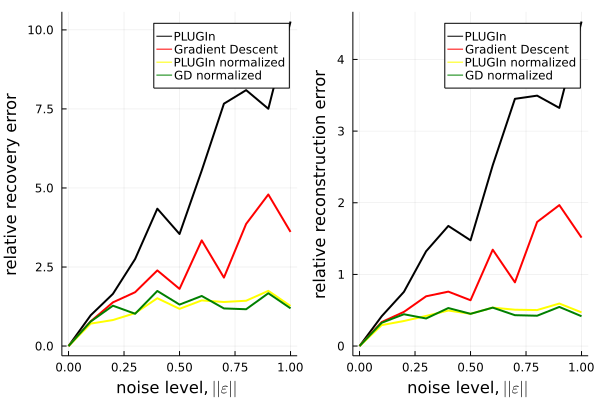

In [30]:
net_param = [5, 200, 750]
G = create_network(net_param)
W = normalized_weight_product(G)
#################################
scale = 1
p1, p2 = SNR(G, scale)
plot(p1, p2, layout = (1,2))

In the experiment, we assume $\|x^*\| = 20$.

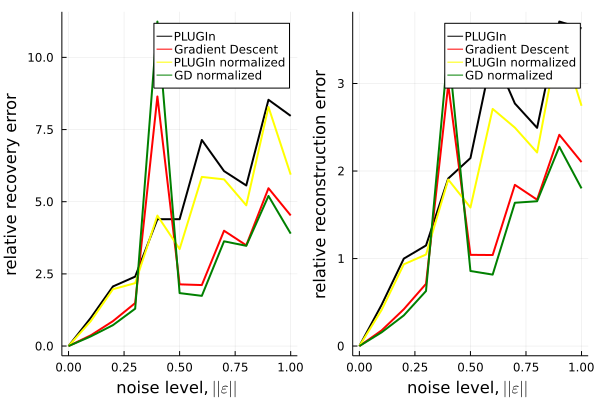

In [31]:
#########  SNR  #################
net_param = [5, 200, 750]
G = create_network(net_param)
W = normalized_weight_product(G)
#################################
scale = 20
p1, p2 = SNR(G, scale)
plot(p1, p2, layout = (1,2))

In the experiment, we assume $\|x^*\| = 1/20$.

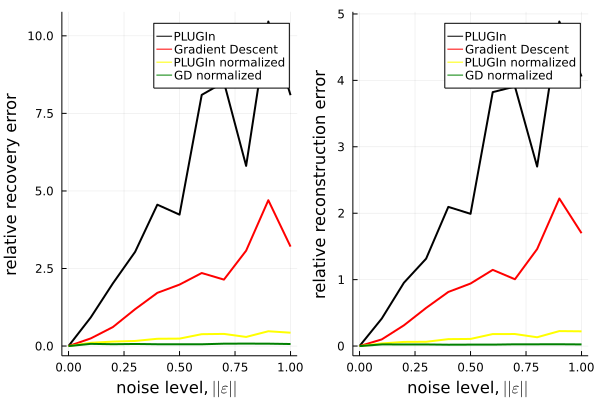

In [32]:
#########  SNR  #################
net_param = [5, 200, 750]
G = create_network(net_param)
W = normalized_weight_product(G)
#################################
scale = 1/20
p1, p2 = SNR(G, scale)
plot(p1, p2, layout = (1,2))

The normalized Gradient descent and normalized PLUGIn estimates (say $x$) satsifies $\|x - x^* \| \sim \|x^* \| \epsilon$, where $\epsilon$ is noise.

In [27]:
#function used to plot the SNR
function SNR(G)
    depth = length(Flux.params(G))/2

    (_, z_dim) = size(Flux.params(G)[1]);
    (x_dim, _ ) = size(Flux.params(G)[Int(depth*2 - 1)])
    W = normalized_weight_product(G)

    max_iter = 1000
    stepsize = .5

    noise_level_list = 0:.1:1
    trials = 4

    recov_error_matrix_PLUGIn = zeros(length(noise_level_list))
    recon_error_matrix_PLUGIn = zeros(length(noise_level_list))

    recov_error_matrix_PLUGIn_norm = zeros(length(noise_level_list))
    recon_error_matrix_PLUGIn_norm = zeros(length(noise_level_list))

    recov_error_matrix_GD = zeros(length(noise_level_list))
    recon_error_matrix_GD = zeros(length(noise_level_list))

    recov_error_matrix_GD_norm = zeros(length(noise_level_list))
    recon_error_matrix_GD_norm = zeros(length(noise_level_list))

    for trial in 1:trials

        recov_error_PLUGIn = []
        recon_error_PLUGIn = []

        recov_error_PLUGIn_norm = []
        recon_error_PLUGIn_norm = []

        recov_error_GD = []
        recon_error_GD = []

        recov_error_GD_norm = []
        recon_error_GD_norm = []

        z = randn(z_dim)
        scale = sqrt(z_dim)

        # z = scale*z/norm(z)
        
        for noise_level in noise_level_list
            y = G(z) + noise_level * randn(x_dim)
            descent(z) = gradient(z->norm(G(z) - y,2)^2, z)[1]        

            z_est_PLUGIn = randn(z_dim)
            z_est_PLUGIn_norm = randn(z_dim)
            z_est_GD = randn(z_dim)
            z_est_GD_norm = randn(z_dim)
            iter = 1
            for iter in 1:max_iter
                z_est_PLUGIn = PLUGIN_denoise(G, W, y, z_est_PLUGIn, stepsize)
                if iter < floor(max_iter*.95)
                    z_est_PLUGIn_norm = PLUGIN_denoise_normalized(G, W, y, z_est_PLUGIn_norm, stepsize, scale)
                else
                    z_est_PLUGIn_norm = PLUGIN_denoise(G, W, y, z_est_PLUGIn_norm, stepsize)
                end
                d = descent(z_est_GD); z_est_GD -= stepsize *d

                d = descent(z_est_GD_norm); z_est_GD_norm -= stepsize *d;
                if iter < floor(max_iter*.95)
                     z_est_GD_norm = z_est_GD_norm * scale / norm(z_est_GD_norm)
                end
            end

            push!(recov_error_PLUGIn, relative_error(z, z_est_PLUGIn))
            push!(recon_error_PLUGIn,  relative_error(G(z), G(z_est_PLUGIn)) )

            push!(recov_error_PLUGIn_norm,  relative_error(z, z_est_PLUGIn_norm))
            push!(recon_error_PLUGIn_norm,  relative_error(G(z), G(z_est_PLUGIn_norm)) )

            push!(recov_error_GD,  relative_error(z, z_est_GD))
            push!(recon_error_GD,  relative_error(G(z), G(z_est_GD)) )  

            push!(recov_error_GD_norm,  relative_error(z, z_est_GD))
            push!(recon_error_GD_norm, relative_error(G(z), G(z_est_GD)) )  

        end

        recov_error_matrix_PLUGIn = hcat(recov_error_matrix_PLUGIn, recov_error_PLUGIn)
        recon_error_matrix_PLUGIn =  hcat(recon_error_matrix_PLUGIn, recon_error_PLUGIn)

        recov_error_matrix_PLUGIn_norm = hcat(recov_error_matrix_PLUGIn_norm, recov_error_PLUGIn_norm)
        recon_error_matrix_PLUGIn_norm =  hcat(recon_error_matrix_PLUGIn_norm, recon_error_PLUGIn_norm)

        recov_error_matrix_GD = hcat(recov_error_matrix_GD, recov_error_GD)
        recon_error_matrix_GD = hcat(recon_error_matrix_GD, recon_error_GD)

        recov_error_matrix_GD_norm = hcat(recov_error_matrix_GD_norm, recov_error_GD_norm)
        recon_error_matrix_GD_norm = hcat(recon_error_matrix_GD_norm, recon_error_GD_norm)

    end

    average_recov = mean(recov_error_matrix_PLUGIn[:, 2:end], dims=2)
    std_recov = std(recov_error_matrix_PLUGIn[:, 2:end], dims=2)
    # plot(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = 0.1, c = 0, label = false)
    plot(noise_level_list, average_recov, label = "PLUGIn", xlabel = "noise level, \$||\\epsilon||\$", ylabel = "average relateive recovery error", linewidth = 2, c =:black)
    
    average_recov = mean(recov_error_matrix_GD[:, 2:end], dims=2)
    std_recov = std(recov_error_matrix_GD[:, 2:end], dims=2)
    # plot!(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov,fillalpha = 0.2, c = 2, label = false)
    plot!(noise_level_list, average_recov, label = "Gradient Descent", xlabel = "noise level, \$||\\epsilon||\$", ylabel = "relative recovery error", linewidth = 2, c =:red)
    

    average_recov = mean(recov_error_matrix_PLUGIn_norm[:, 2:end], dims=2)
    std_recov = std(recov_error_matrix_PLUGIn_norm[:, 2:end], dims=2)
    # plot!(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = 0.3, c = 9, label = false)
    plot!(noise_level_list, average_recov, label = "PLUGIn normalized", xlabel = "noise level, \$||\\epsilon||\$", ylabel = "relative recovery error", linewidth = 2, c =:yellow)

    average_recov = mean(recov_error_matrix_GD_norm[:, 2:end], dims=2)
    std_recov = std(recov_error_matrix_GD_norm[:, 2:end], dims=2)
    # plot!(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = 0.4, c = 9, label = false)
    p1 = plot!(noise_level_list, average_recov, label = "GD normalized", xlabel = "noise level, \$||\\epsilon||\$", ylabel = "relative recovery error", linewidth = 2, c =:green)
    
    
    average_recon = mean(recon_error_matrix_PLUGIn[:, 2:end], dims=2)
    std_recon = std(recon_error_matrix_PLUGIn[:, 2:end], dims=2)
    # plot(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon, fillalpha = 0.1, c = 0, label = false)
    plot(noise_level_list, average_recon, label = "PLUGIn", xlabel = "noise level, \$||\\epsilon||\$ ", ylabel = "relative reconstruction error", linewidth = 2 , c =:black)
    

    average_recon = mean(recon_error_matrix_GD[:, 2:end], dims=2)
    std_recon = std(recon_error_matrix_GD[:, 2:end], dims=2)
    # plot!(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon,fillalpha = 0.2, c = 2, label = false)
    plot!(noise_level_list, average_recon, label = "Gradient Descent", xlabel = "noise level, \$||\\epsilon||\$", ylabel = "relative reconstruction error", linewidth = 2, c =:red)
    
    average_recon = mean(recon_error_matrix_PLUGIn_norm[:, 2:end], dims=2)
    std_recon = std(recon_error_matrix_PLUGIn_norm[:, 2:end], dims=2)
    # plot!(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon, fillalpha = 0.3, c = 9, label = false)
    plot!(noise_level_list, average_recon, label = "PLUGIn normalized", xlabel = "noise level, \$||\\epsilon||\$", ylabel = "relative reconstruction error", linewidth = 2 , c =:yellow)

    average_recon = mean(recon_error_matrix_GD_norm[:, 2:end], dims=2)
    std_recon = std(recon_error_matrix_GD_norm[:, 2:end], dims=2)
    # plot!(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon, fillalpha = 0.4, c = 9, label = false)
    p2 = plot!(noise_level_list, average_recon, label = "GD normalized", xlabel = "noise level, \$||\\epsilon||\$", ylabel = "relative reconstruction error", linewidth = 2 , c =:green)
    
    return p1, p2
end

SNR (generic function with 2 methods)

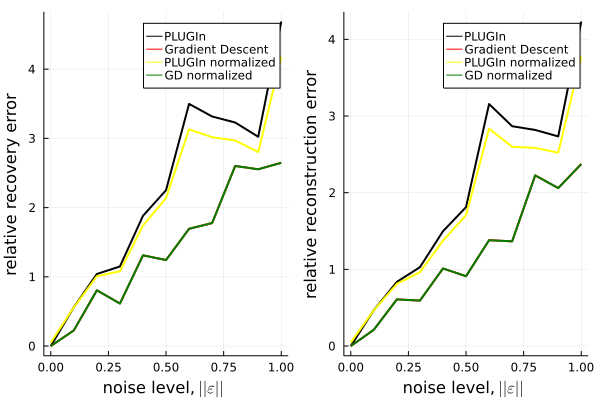

In [28]:
#########  SNR  #################
net_param = [5, 200, 750]
G = create_network(net_param)
W = normalized_weight_product(G)
#################################
p1, p2 = SNR(G)
plot(p1, p2, layout = (1,2))